In [1]:
from get_data import *
from dataloader import *
#from NN_classes import *
#from experiments import *
from NN_classes_NEW import *
import numpy as np
from test_function_exp_NEW import *

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

In [ ]:
 #trigger for pop out plots
%matplotlib qt
 #trigger for plots in cells
%matplotlib inline

In [ ]:
colors = {  "lstm_or_nextstep" : "red" ,
            "mlp_or_nextstep" : "green" ,
            "tcn_or_nextstep" : "orange" ,
            "lstm_no_or_nextstep" : "green" ,
            "mlp_no_or_nextstep" : "red" ,
            "tcn_no_or_nextstep" : "orange" ,
            "lstm_derivative" : "orange" ,
            "mlp_derivative" : "red" ,
            "tcn_derivative" : "green" ,
            "or_lstm" : "yellow" ,
            "lstm" : "red" ,
            "mlp" : "red" ,
            "gru" : "red" ,
            "tcn" : "red" ,
            "or_tcn" : "darkgreen" ,
            "neural_cde" : "red" ,
            "or_mlp" : "tomato"}

In [2]:
# This file contains all the experiments to compare the trained models 
import numpy as np

def exp1(models: dict, data, window_sizes, plot_errs=False, set_random=False, bins=10):
    
    if set_random:
         np.seed(1234)
    
    # if plot_errs==False:
    #     index = np.random.randint(0, data.size(dim=0),1)[0]
    #     data = data[index:index+1,:,:]

    device = "cpu" if data.get_device() == -1 else "cuda:0"
    timesteps = data.size(dim=1)
    loss_fn = torch.nn.MSELoss()

    predictionary = {}
    error_dict = {model_type : [] for model_type in list(models.keys())}
    with torch.inference_mode():
        for model_type, model in models.items():
        
            model.eval()
            
            if plot_errs:
                for i , x in enumerate(data):
                    pred, error = test(data[i:i+1,:,:], model, model_type, window_size=window_sizes[model_type], set_rand_seed=True)
                    predictionary[model_type] = pred
                    error_dict[model_type].append(error)  
            else:
                    pred, error = test(data, model, model_type, window_size=window_sizes[model_type], set_rand_seed=True)
                    predictionary[model_type] = pred
                        
        if plot_errs:
                plot_errors(error_dict, bins)
                
        else:
                #phase_plot_predictions(predictionary, data.clone())
                plot_predictions(predictionary, data.clone())

def plot_predictions(predictionary, x):
    
    data_dic = {x : y.clone() for x, y in predictionary.items()}

    p_max = 3.5*1e5 #Druck in [bar]         ... [1 , 3.5]
    s_max = 0.6*1e-3 #Position [m]          ... [0, 0.0006]
    w_max = 1.7 #Geschwindigkeit in [m/s]   ... [-1.7, 1.7]
    p_min = 1.0
    s_min = 0.0
    w_min = -1.7
    physics_rescaling = [p_max, s_max, w_max, p_min, s_min, w_min]

    colors = {  "lstm_or_nextstep" : "red" ,
            "mlp_or_nextstep" : "green" ,
            "tcn_or_nextstep" : "orange" ,
            "lstm_no_or_nextstep" : "green" ,
            "mlp_no_or_nextstep" : "red" ,
            "tcn_no_or_nextstep" : "orange" ,
            "lstm_derivative" : "orange" ,
            "mlp_derivative" : "red" ,
            "tcn_derivative" : "green" ,
            "or_lstm" : "yellow" ,
            "lstm" : "red" ,
            "mlp" : "red" ,
            "gru" : "red" ,
            "tcn" : "red" ,
            "or_tcn" : "darkgreen" ,
            "neural_cde" : "red" ,
            "or_mlp" : "tomato"}
    
    if "or_lstm" in list(data_dic.keys()) and "lstm_or_nextstep" in list(predictionary.keys()):
        colors = {"or_lstm" : "red", "lstm_or_nextstep" : "yellow", "lstm_no_or_nextstep" : "green", "lstm_derivative" : "purple"}

    figure , axs = plt.subplots(3,1, figsize=(16,9))
    figure.tight_layout(pad=5.0)    

    if x.dim() == 3:
        x = x.view(x.size(dim=1), x.size(dim=2))
    
        #scale back:    
    if physics_rescaling != None:

        x[:,0] = x[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
        x[:,1] = x[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        x[:,2] = x[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    greek_letterz=[chr(code) for code in range(945,970)]
    mu = greek_letterz[11]

    stepsize = 2e-5
    time = np.linspace(0,x.size(dim=0)* stepsize, x.size(dim=0))

    #data
    axs[0].plot(time, x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
    axs[1].plot(time, x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
    axs[2].plot(time, x.detach().cpu().numpy()[:,0], label="pressure")

    #predictions
    for key, pred in data_dic.items():

        if physics_rescaling != None:

            # we invert:
            # x = (x - xmin)/(xmax - xmin)
            # x * (xmax - xmin) + xmin

            pred[:,0] = pred[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
            pred[:,1] = pred[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
            pred[:,2] = pred[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

        if pred.dim() == 3:
            pred = pred.view(pred.size(dim=1), pred.size(dim=2))

        axs[0].plot(time, pred.detach().cpu().numpy()[:, 1], color=colors[key], label=f"{key}-prediciton", alpha=0.8)
        axs[1].plot(time, pred.detach().cpu().numpy()[:, 2], color=colors[key], label=f"{key}-prediciton", alpha=0.8)


    axs[0].set_title("position")
    axs[0].set_ylabel("[m]")
    axs[0].set_xlabel(f"time [s]")
    axs[0].grid()
    axs[0].legend()   
    axs[1].set_title("speed")
    axs[1].set_ylabel("[m/s]")
    axs[1].set_xlabel(f"time [s]")
    axs[1].grid()
    axs[1].legend()
    axs[2].set_title("pressure")
    axs[2].set_ylabel("[Pa]")
    axs[2].set_xlabel(f"time [s]")
    axs[2].grid()
    axs[2].legend()

    plt.grid(True)
    plt.legend()
    plt.show()


def phase_plot_predictions(predictionary, x):


    data_dic = {x : y.clone() for x, y in predictionary.items()}

    p_max = 3.5*1e5 #Druck in [bar]         ... [1 , 3.5]
    s_max = 0.6*1e-3 #Position [m]          ... [0, 0.0006]
    w_max = 1.7 #Geschwindigkeit in [m/s]   ... [-1.7, 1.7]
    p_min = 1.0
    s_min = 0.0
    w_min = -1.7
    physics_rescaling = [p_max, s_max, w_max, p_min, s_min, w_min]

    colors = {  "lstm_or_nextstep" : "red" ,
            "mlp_or_nextstep" : "green" ,
            "tcn_or_nextstep" : "orange" ,
            "lstm_no_or_nextstep" : "green" ,
            "mlp_no_or_nextstep" : "red" ,
            "tcn_no_or_nextstep" : "orange" ,
            "lstm_derivative" : "orange" ,
            "mlp_derivative" : "red" ,
            "tcn_derivative" : "green" ,
            "or_lstm" : "yellow" ,
            "lstm" : "red" ,
            "mlp" : "red" ,
            "gru" : "red" ,
            "tcn" : "red" ,
            "or_tcn" : "darkgreen" ,
            "neural_cde" : "red" ,
            "or_mlp" : "tomato"}

    figure , axs = plt.subplots(1,1, figsize=(16,16))
    figure.tight_layout(pad=5.0)    

    if x.dim() == 3:
        x = x.view(x.size(dim=1), x.size(dim=2))
    
        #scale back:    
    if physics_rescaling != None:

        x[:,0] = x[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
        x[:,1] = x[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        x[:,2] = x[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    greek_letterz=[chr(code) for code in range(945,970)]
    mu = greek_letterz[11]

    stepsize = 2e-5
    time = np.linspace(0,x.size(dim=0)* stepsize, x.size(dim=0))

    #data
    axs.plot(x.detach().cpu().numpy()[:, 1],x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")

    #predictions
    for key, pred in data_dic.items():

        if physics_rescaling != None:

            # we invert:
            # x = (x - xmin)/(xmax - xmin)
            # x * (xmax - xmin) + xmin

            pred[:,0] = pred[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
            pred[:,1] = pred[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
            pred[:,2] = pred[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

        if pred.dim() == 3:
            pred = pred.view(pred.size(dim=1), pred.size(dim=2))

        axs.plot(pred.detach().cpu().numpy()[:, 1], pred.detach().cpu().numpy()[:, 2], color=colors[key], label=f"{key}-prediciton", alpha=0.8)

    axs.set_title("phaseplot")
    axs.set_ylabel("[m/s]")
    axs.set_xlabel(f"[m]")
    axs.grid()
    axs.legend()   


    plt.grid(True)
    plt.legend()
    plt.show()


def plot_errors(erros_dic, bins):
     
    data_dic = {x : y for x, y in erros_dic.items()}
    # Plot histograms with MSE over many trajectories
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = {  "lstm_or_nextstep" : "red" ,
            "mlp_or_nextstep" : "green" ,
            "tcn_or_nextstep" : "orange" ,
            "lstm_no_or_nextstep" : "green" ,
            "mlp_no_or_nextstep" : "red" ,
            "tcn_no_or_nextstep" : "orange" ,
            "lstm_derivative" : "orange" ,
            "mlp_derivative" : "red" ,
            "tcn_derivative" : "green" ,
            "or_lstm" : "yellow" ,
            "lstm" : "red" ,
            "mlp" : "red" ,
            "gru" : "red" ,
            "tcn" : "red" ,
            "or_tcn" : "darkgreen" ,
            "neural_cde" : "red" ,
            "or_mlp" : "tomato"}

    # Plot each histogram on the same axes
    for key, values in data_dic.items():
        #plt.plot(np.array(values))
        ax.hist(np.array(values).flatten(), bins=bins, alpha=0.7, label=key)
        ax.axvline(np.array(values).mean(), color=colors[key], linestyle='dashed', linewidth=2, label=f"{key} : Mean MSE {np.round(np.array(values).mean(),7)}")

    # Set titles and labels
    ax.set_title('Mean squared errors over X trajectories')
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency')
    ax.grid(True)

    # Add a legend
    ax.legend()
    # Display the plot
    plt.show()
    return None

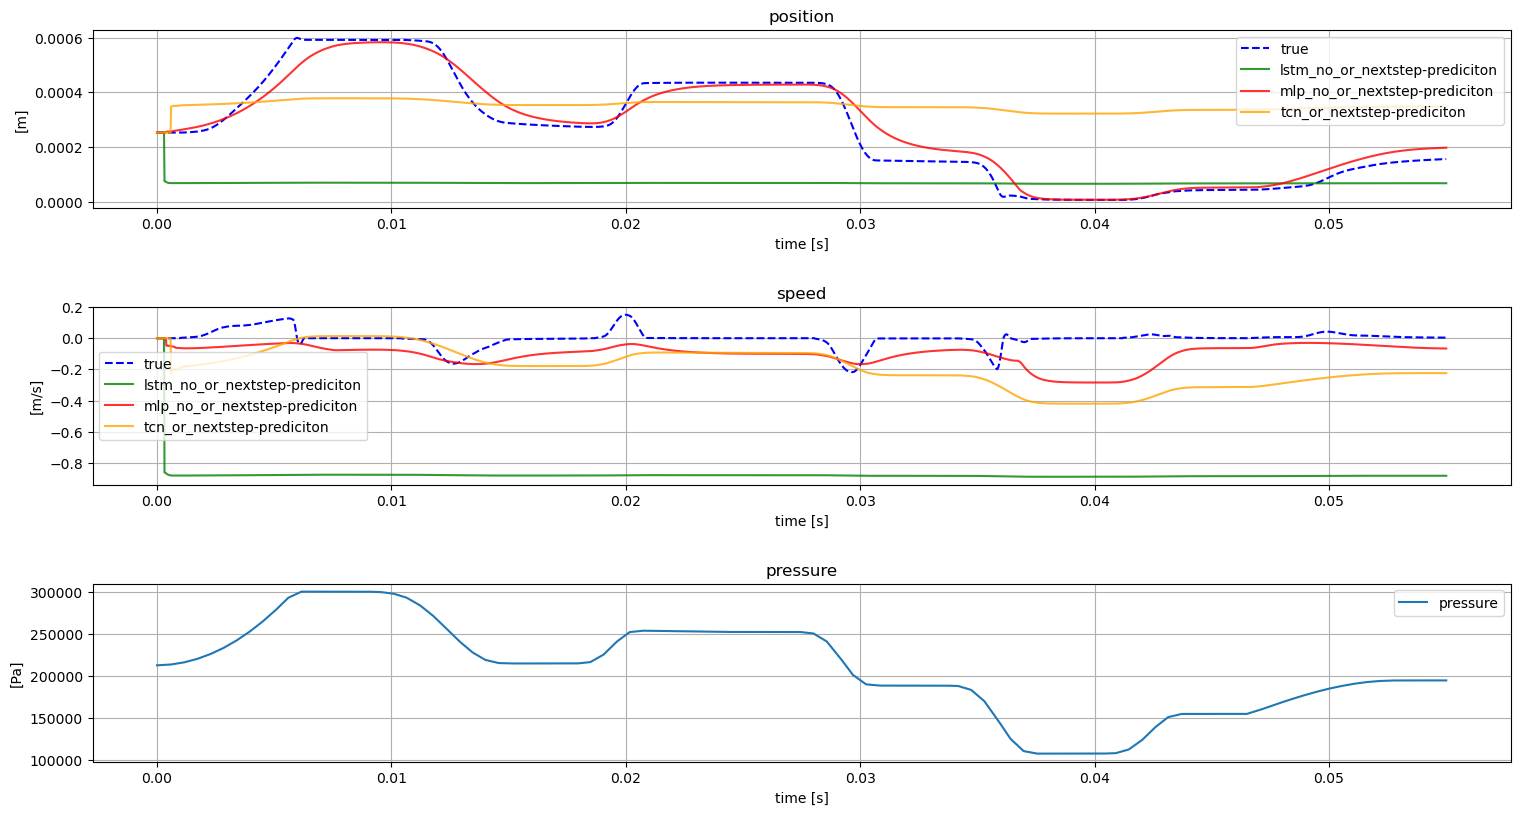

In [5]:
#Test trajectories

params_lstm =   {
                        "window_size" : 16,
                        "h_size" : 8,
                        "l_num" : 3,
                        "learning_rate" : 0.0008,
                        "batch_size" : 20,
                }

params_mlp =    {
                        "window_size" : 20,
                        "h_size" : 24,
                        "l_num" : 3,
                        "learning_rate" : 0.001,
                        "batch_size" : 20,
                        "act_fn" : "relu",
                        "nonlin_at_out" : None #None if no nonlinearity at the end
                }

params_tcn =    {
                    "window_size" : 30,
                    "learning_rate" : 0.001,
                    "batch_size" : 20,
                    "n_hidden" : 5,
                    "levels" : 4,
                    "kernel_size" : 7,
                    "dropout" : 0,
                    "input_channels" : 3,
                    "output" : 2,
                    "drop_half_timesteps" : True,
                    "cut_off_timesteps" : 100,
                    "part_of_data" : 0,
                    "percentage_of_data" : 0.8

                }
    
parameter_configs  = [params_lstm, params_mlp, params_tcn] 

path = "data\save_data_test_5xlonger_dyndyn.csv"
path2 = "data\save_data_test_5xlonger.csv"
#path = "data\save_data_test_revised.csv"
input_data, PSW_max = get_data(path = path, 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params_tcn["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params_tcn["part_of_data"])

input_data2, PSW_max = get_data(path = path2, 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params_tcn["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params_tcn["part_of_data"])
input_data = torch.cat((input_data, input_data2))
#print(input_data.size())

np.random.seed(1234)
#print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params_tcn["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

#load models

# Initialize the LSTM models
model_lstm = OR_LSTM(input_size=3, hidden_size=params_lstm["h_size"], out_size=2, layers=params_lstm["l_num"], window_size=params_lstm["window_size"]).to(device)
path_lstm = "First_experiment_run_22_07_2024\OR_LSTM_exp0.pth"
model_lstm.load_state_dict(torch.load(path_lstm, map_location=torch.device(device)))

model_lstm_nextstep = LSTM_or_nextstep(input_size=3, hidden_size=params_lstm["h_size"], out_size=2, layers=params_lstm["l_num"], window_size = params_lstm["window_size"]).to(device)
path_lstm_nextstep = "First_experiment_run_22_07_2024\LSTM_or_nextstep_exp0.pth"
model_lstm_nextstep.load_state_dict(torch.load(path_lstm_nextstep, map_location=torch.device(device)))

model_lstm_no_or_nextstep = LSTM_or_nextstep(input_size=3, hidden_size=params_lstm["h_size"], out_size=2, layers=params_lstm["l_num"], window_size = params_lstm["window_size"]).to(device)
path_lstm_no_or_nextstep = "First_experiment_run_22_07_2024\LSTM_no_or_nextstep_exp0.pth"
model_lstm_no_or_nextstep.load_state_dict(torch.load(path_lstm_no_or_nextstep, map_location=torch.device(device)))

model_lstm_no_or_derivative = OR_LSTM(input_size=3, hidden_size=params_lstm["h_size"], out_size=2, layers=params_lstm["l_num"], window_size = params_lstm["window_size"]).to(device)
path_lstm_no_or_derivative = "Trained_NNs_exp\LSTM_derivative_exp0.pth"
model_lstm_no_or_derivative.load_state_dict(torch.load(path_lstm_no_or_derivative, map_location=torch.device(device)))


# Initialize the MLP models
model_or_mlp = OR_MLP(input_size=3*params_mlp["window_size"], hidden_size = params_mlp["h_size"], l_num=params_mlp["l_num"], output_size=2, act_fn = params_mlp["act_fn"],
                    act_at_end = params_mlp["nonlin_at_out"], timesteps=params_mlp["window_size"]).to(device)
path_or_mlp = "First_experiment_run_22_07_2024\OR_MLP_exp1.pth"
model_or_mlp.load_state_dict(torch.load(path_or_mlp, map_location=torch.device(device)))

model_or_mlp_nextstep = MLP_or_nextstep(input_size=3*params_mlp["window_size"], hidden_size = params_mlp["h_size"], l_num=params_mlp["l_num"],
                output_size=2, act_fn = params_mlp["act_fn"], act_at_end = params_mlp["nonlin_at_out"], timesteps=params_mlp["window_size"]).to(device)
path_or_mlp_nextstep = "First_experiment_run_22_07_2024\MLP_or_nextstep_exp1.pth"
model_or_mlp_nextstep.load_state_dict(torch.load(path_or_mlp_nextstep, map_location=torch.device(device)))

model_mlp_no_or_nextstep = MLP_or_nextstep(input_size=3*params_mlp["window_size"], hidden_size = params_mlp["h_size"], l_num=params_mlp["l_num"],
                output_size=2, act_fn = params_mlp["act_fn"], act_at_end = params_mlp["nonlin_at_out"], timesteps=params_mlp["window_size"]).to(device)
path_mlp_no_or_nextstep = "Trained_NNs_exp\MLP_no_or_nextstep_exp1.pth"
model_mlp_no_or_nextstep.load_state_dict(torch.load(path_mlp_no_or_nextstep, map_location=torch.device(device)))

model_mlp_no_or_derivative = OR_MLP(input_size=3*params_mlp["window_size"], hidden_size = params_mlp["h_size"], l_num=params_mlp["l_num"],
                output_size=2, act_fn = params_mlp["act_fn"], act_at_end = params_mlp["nonlin_at_out"], timesteps=params_mlp["window_size"]).to(device)
path_mlp_no_or_derivative = "Trained_NNs_exp\MLP_derivative_exp1.pth"
model_mlp_no_or_derivative.load_state_dict(torch.load(path_mlp_no_or_derivative, map_location=torch.device(device)))

# Initialize the TCN models
input_channels = params_tcn["input_channels"]
output = params_tcn["output"]
num_channels = [params_tcn["n_hidden"]] * params_tcn["levels"]
kernel_size = params_tcn["kernel_size"]
dropout = params_tcn["dropout"]

model_tcn = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
path_tcn = "First_experiment_run_22_07_2024\OR_TCN_exp2.pth"
model_tcn.load_state_dict(torch.load(path_tcn, map_location=torch.device(device)))

model_tcn_nextstep = TCN_or_nextstep(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
path_tcn_nextstep = "First_experiment_run_22_07_2024\TCN_or_nextstep_exp2.pth"
model_tcn_nextstep.load_state_dict(torch.load(path_tcn_nextstep, map_location=torch.device(device)))

#model_tcn_no_or_nextstep = TCN_no_or_nextstep(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
model_tcn_no_or_nextstep = TCN_or_nextstep(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
path_tcn_no_or_nextstep = "First_experiment_run_22_07_2024\TCN_no_or_nextstep_exp2.pth"
model_tcn_no_or_nextstep.load_state_dict(torch.load(path_tcn_no_or_nextstep, map_location=torch.device(device)))

model_tcn_no_or_derivative = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)
path_tcn_no_or_derivative = "Trained_NNs_exp\TCN_derivative_exp2.pth"
model_tcn_no_or_derivative.load_state_dict(torch.load(path_tcn_no_or_derivative, map_location=torch.device(device)))


# TODO Neural CDE  
#model = NeuralCDE(input_channels=4, hidden_channels=params["h_size"], hidden_width = params["h_width"], output_channels=2).to(device)
#model.load_state_dict(torch.load(path, map_location=torch.device(device)))

models = {"or_lstm" : model_lstm,
          "or_mlp" : model_or_mlp,
          #"mlp" : model_mlp,
          "or_tcn" : model_tcn
          }

window_sizes = {"or_lstm" : params_lstm["window_size"],
                "or_mlp" : params_mlp["window_size"],
                "mlp" : params_mlp["window_size"],
                "or_tcn" : params_tcn["window_size"],
                "lstm_or_nextstep" : params_lstm["window_size"],
                "mlp_or_nextstep" : params_mlp["window_size"],
                "tcn_or_nextstep" : params_tcn["window_size"],
                "lstm_no_or_nextstep" : params_lstm["window_size"],
                "mlp_no_or_nextstep" : params_mlp["window_size"],
                "tcn_no_or_nextstep" : params_tcn["window_size"]
                }
    
models_nextstep = {"lstm_or_nextstep" : model_lstm_nextstep,
          "mlp_or_nextstep" : model_or_mlp_nextstep,
          #"mlp" : model_mlp,
          "tcn_or_nextstep" : model_tcn_nextstep
          }

fixed_model_categories = {"tcn_or_nextstep" : model_tcn_nextstep, 
                          "or_tcn" : model_tcn}

models_no_or_nextstep = {"lstm_no_or_nextstep" : model_lstm_no_or_nextstep,
                          "mlp_no_or_nextstep" : model_mlp_no_or_nextstep,
                             "tcn_or_nextstep" : model_tcn_no_or_nextstep   } # 

models_no_or_derivative = {"or_lstm" : model_lstm_no_or_derivative,
                          "or_mlp" : model_mlp_no_or_derivative,
                          "or_tcn" : model_tcn_no_or_derivative }     # 



np.random.seed(1234)

test_inits = input_data.size(dim=0)
ids = np.random.choice(test_inits, min([input_data.size(dim=0), 10]), replace=False)
ids = np.unique(ids)

# Use k=4 as test trajectory for all plots
k=4

exp1(models_no_or_nextstep, input_data[k:k+1,:,:], window_sizes, plot_errs=False, bins=7)


In [ ]:
input_data.size()
k=34
print(input_data[k:k+1, 0:params_tcn["window_size"], :].transpose(1,2))
a = model_tcn_no_or_nextstep(input_data[k:k+1, 0:params_tcn["window_size"], :].transpose(1,2))
print(a)
print(input_data[k:k+1, params_tcn["window_size"]-1, :].size())
print(input_data[k:k+1, params_tcn["window_size"]-1, 1:]-a)

In [ ]:
def normlist(a):
    return [ (x - min(a)) / (max(a) - min(a)) for x in a]

Epochs = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
LSTM = [0.028456646258258722, 0.022694337263373117, 0.026009841374953605, 0.03045055947042709, 0.019146433432510185, 0.0076781917215315715, 0.00730898111993305, 0.007876552085049473, 0.007547752849599885, 0.006278254707170924]
# MLP hat ausreißer
#MLP = [0.01856441755029323, 0.013231895836598232, 0.010403810288739296, 0.008548521189701832, 0.009579918550359865, 0.008980504622523996, 0.009289483926369347, 0.006702352100843063, 3599.2784327571107, 0.009543711781792218]
MLP = [0.01856441755029323, 0.013231895836598232, 0.010403810288739296, 0.008548521189701832, 0.009579918550359865, 0.008980504622523996, 0.009289483926369347, 0.006702352100843063, 0.006702352100843063, 0.009543711781792218]
TCN = [0.03306022808310429, 0.012185637813547628, 0.008335839578852183, 0.0038785364358451145, 0.0031343244156947217, 0.003462088193589699, 0.003981136428790162, 0.002496261116017282, 0.0026503715556096402, 0.0020942350182145074]
#MLP = normlist(MLP)
#LSTM = normlist(LSTM)
#TCN = normlist(TCN)
LSTM2 = [0.024987961961632846, 0.016181169585631445, 0.014161591938671236, 0.01406885179196545, 0.012409247708514435, 0.010494681192992274, 0.008844779220702037, 0.006999178763346141, 0.006394357812348286, 0.005090870408819805]
MLP2 = [0.0198861211717555, 0.010500711235144832, 0.007480574647699809, 0.006824193687648814, 0.006275183383519934, 0.004428913574496422, 0.003949885732163199, 0.0032829739688022457, 0.0035847660291489, 0.003276470429756819]
TCN2 = [0.01730283516845159, 0.01574904319763183, 0.013428775159859312, 0.010616026681713377, 0.006429868407236622, 0.006101762805938836, 0.006622495231124482, 0.007598870176500983, 0.00687686763729292, 0.004873080602545475]


fig, axs = plt.subplots(2,2, figsize=(16,9))
fig.tight_layout(pad=3.0)

for i,j in [(0,0), (1,0), (0,1), (1,1)]:
    axs[i,j].grid(True)
    axs[i,j].set_ylabel("MSE")
    axs[i,j].set_xlabel("Epochs")
    #axs[i,j].legend()

axs[0,0].plot(Epochs, LSTM, color="b", label = "LSTM")
axs[0,0].plot(Epochs, MLP, color="g", label = "MLP")
axs[0,0].plot(Epochs, TCN, color="r", label = "TCN")
axs[0,0].set_title("OR-derivative")
axs[0,0].legend()

axs[1,0].plot(Epochs, LSTM2, color="b", label = "LSTM")
axs[1,0].plot(Epochs, MLP2, color="g", label = "MLP")
axs[1,0].plot(Epochs, TCN2, color="r", label = "TCN")
axs[1,0].set_title("OR-Nextstep")
axs[1,0].legend()

axs[0,1].plot(Epochs, LSTM, color="b", label = "LSTM")
axs[0,1].plot(Epochs, MLP, color="g", label = "MLP")
axs[0,1].plot(Epochs, TCN, color="r", label = "TCN")
axs[0,1].set_title("derivative")
axs[0,1].legend()

axs[1,1].plot(Epochs, LSTM, color="b", label = "LSTM")
axs[1,1].plot(Epochs, MLP, color="g", label = "MLP")
axs[1,1].plot(Epochs, TCN, color="r", label = "TCN")
axs[1,1].set_title("Nextstep")
axs[1,1].legend()


